In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

eval_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_eval_videos'
os.makedirs(eval_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = [                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
    
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500',

]

# Get vizualization for single session

In [4]:
sample_course = '05410B'
sample_session_id = 'classinsight-cmu_05410B_ghc_4211_201904081500-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05410B/classinsight-cmu_05410B_ghc_4211_201904081500-front'

In [5]:
session_video_file

'/mnt/ci-nas-classes/classinsight/2019S/video_backup/classinsight-cmu_05410B_ghc_4211_201904081500/classinsight-cmu_05410B_ghc_4211_201904081500-front.avi'

In [6]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


8 29
11 16
11 17
11 26
14 19
18 29
Dict: eligible_id_map_dict
Key: Value


{16: 11, 17: 11, 18: 8, 19: 14, 26: 11, 29: 8}

Dict: eligible_id_map_dict
Key: Value


{16: 11, 17: 11, 18: 8, 19: 14, 26: 11, 29: 8}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 86:16 -->11
replacing 87:17 -->11
replacing 105:18 -->8
replacing 121:19 -->14
replacing 300:26 -->11
replacing 352:29 -->8
replacing 221:16 -->11
replacing 138:19 -->14
replacing 702:16 -->11
replacing 370:26 -->11


In [7]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [8]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,71991,71991
1,1,0,43644,43644
2,2,0,71214,71214
3,3,78,71991,71913
4,4,186,55503,55317
5,5,195,71055,70860
6,6,321,71991,71670
7,7,321,1485,1164
8,8,405,71991,71586
9,9,861,37800,36939


In [9]:
df_id_start_stop.total_idxs.max()*0.1

7199.1

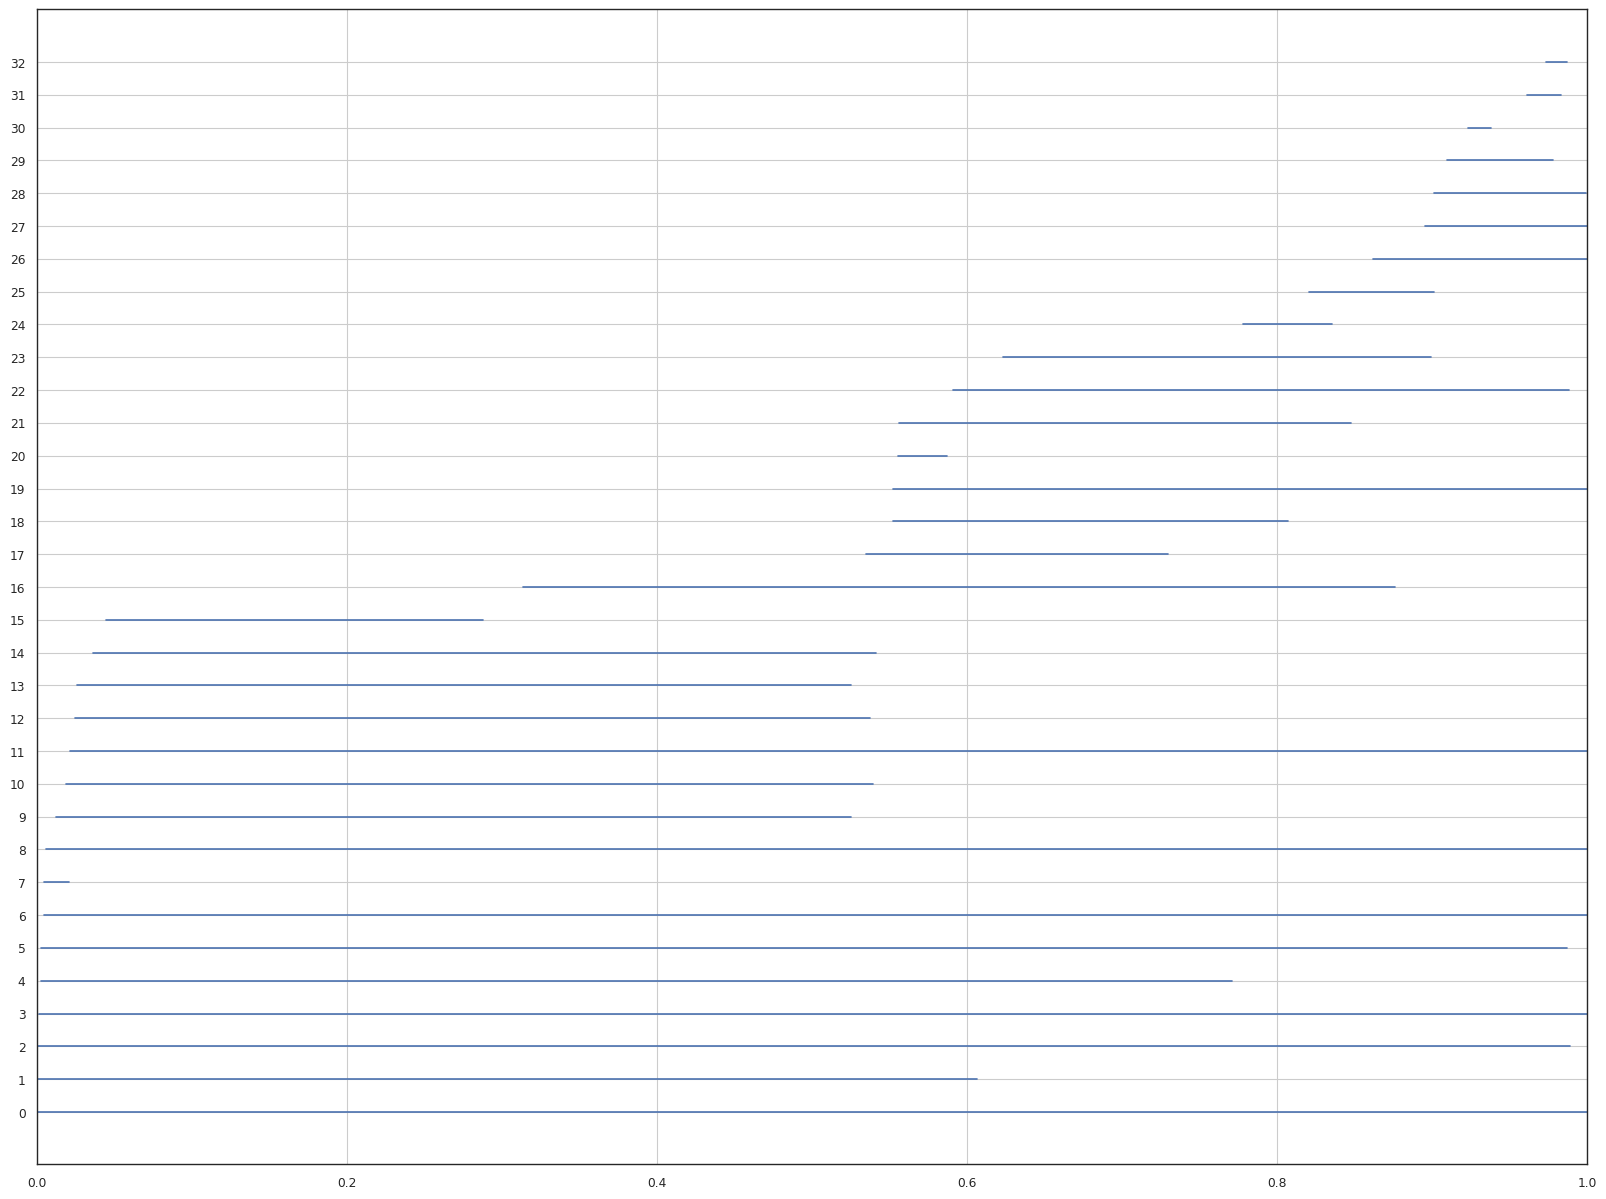

In [10]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [11]:
INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.1
instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
instructor_ids

array([ 7, 24, 30, 31, 34, 35, 36, 37, 38])

In [12]:
# find random frames to mark for GT from session
# np.random.seed(42)

MAX_SESSION_IDX = df_id_start_stop.max_idx.max()
NUM_SEGMENTS =3
SEG_START_MIN = 0.1
SEG_START_MAX=0.9
SET_SIZE = 60*15
SEGMENT_WINDOW_SIZE = (SEG_START_MAX - SEG_START_MIN)/NUM_SEGMENTS

session_frames = df_tracking_new.index.values.tolist()
selected_frames = []
selected_sets = []

for i in range(NUM_SEGMENTS):    
    seg_window =  np.arange(int((SEG_START_MIN + (i*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX), int((SEG_START_MIN + ((i+1)*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX) - SET_SIZE) 
    seg_set_start = np.random.choice(seg_window)
    seg_set_end = seg_set_start+SET_SIZE
    segment_frames = [xr for xr in session_frames if ((xr >= seg_set_start) and (xr<seg_set_end))]
    selected_sets.append((seg_set_start, seg_set_end, segment_frames))
    selected_frames+=segment_frames        

sprint(selected_sets)

List: selected_sets


[
    (
        13184,
        14084,
        [
            13185,
            13188,
            13191,
            13194,
            13197,
            13200,
            13203,
            13206,
            13209,
            13212,
            13215,
            13218,
            13221,
            13224,
            13227,
            13230,
            13233,
            13236,
            13239,
            13242,
            13245,
            13248,
            13251,
            13254,
            13257,
            13260,
            13263,
            13266,
            13269,
            13272,
            13275,
            13278,
            13281,
            13284,
            13287,
            13290,
            13293,
            13296,
            13299,
            13302,
            13305,
            13308,
            13311,
            13314,
            13317,
            13320,
            13323,
            13326,
            13329,
            13332,
            13335,
            13338,
            13341,
            13344,
            13347,
            13350,
            13353,
            13356,
            13359,
            13362,
            13365,
            13368,
            13371,
            13374,
            13377,
            13380,
            13383,
            13386,
            13389,
            13392,
            13395,
            13398,
            13401,
            13404,
            13407,
            13410,
            13413,
            13416,
            13419,
            13422,
            13425,
            13428,
            13431,
            13434,
            13437,
            13440,
            13443,
            13446,
            13449,
            13452,
            13455,
            13458,
            13461,
            13464,
            13467,
            13470,
            13473,
            13476,
            13479,
            13482,
            13485,
            13488,
            13491,
            13494,
            13497,
            13500,
            13503,
            13506,
            13509,
            13512,
            13515,
            13518,
            13521,
            13524,
            13527,
            13530,
            13533,
            13536,
            13539,
            13542,
            13545,
            13548,
            13551,
            13554,
            13557,
            13560,
            13563,
            13566,
            13569,
            13572,
            13575,
            13578,
            13581,
            13584,
            13587,
            13590,
            13593,
            13596,
            13599,
            13602,
            13605,
            13608,
            13611,
            13614,
            13617,
            13620,
            13623,
            13626,
            13629,
            13632,
            13635,
            13638,
            13641,
            13644,
            13647,
            13650,
            13653,
            13656,
            13659,
            13662,
            13665,
            13668,
            13671,
            13674,
            13677,
            13680,
            13683,
            13686,
            13689,
            13692,
            13695,
            13698,
            13701,
            13704,
            13707,
            13710,
            13713,
            13716,
            13719,
            13722,
            13725,
            13728,
            13731,
            13734,
            13737,
            13740,
            13743,
            13746,
            13749,
            13752,
            13755,
            13758,
            13761,
            13764,
            13767,
            13770,
            13773,
            13776,
            13779,
            13782,
            13785,
            13788,
            13791,
            13794,
            13797,
            13800,
            13803,
            13806,


In [13]:
len(selected_frames)

900

In [14]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [15]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0x9aab8c0] error while decoding MB 68 11, bytestream -7
[h264 @ 0x9aab8c0] error while decoding MB 53 90, bytestream -7
[h264 @ 0x9aab8c0] error while decoding MB 213 133, bytestream -7
[h264 @ 0x9e3cb40] error while decoding MB 68 11, bytestream -7
[h264 @ 0x9e369c0] error while decoding MB 53 90, bytestream -7
[h264 @ 0x9ee4b40] error while decoding MB 213 133, bytestream -7
[h264 @ 0x9f21740] error while decoding MB 107 92, bytestream -5
[h264 @ 0x9e3cb40] error while decoding MB 68 11, bytestream -7
[h264 @ 0x9e369c0] error while decoding MB 53 90, bytestream -7
[h264 @ 0x9ee4b40] error while decoding MB 213 133, bytestream -7
[h264 @ 0x9f21740] error while decoding MB 107 92, bytestream -5


Looped 0 images


[h264 @ 0x9f49f40] error while decoding MB 72 118, bytestream -5
[h264 @ 0xb107a80] error while decoding MB 20 85, bytestream -5
[h264 @ 0xbad7480] error while decoding MB 35 95, bytestream -5
[h264 @ 0x9e3cb40] error while decoding MB 106 85, bytestream -5
[h264 @ 0x9f49f40] error while decoding MB 176 126, bytestream -10
[h264 @ 0xb107a80] error while decoding MB 193 104, bytestream -5
[h264 @ 0xbad7480] error while decoding MB 156 116, bytestream -7
[h264 @ 0x9b7c980] error while decoding MB 16 87, bytestream -9
[h264 @ 0x9e3cb40] error while decoding MB 48 85, bytestream -9


Looped 10000 images


[h264 @ 0x9f21740] error while decoding MB 2 133, bytestream -7
[h264 @ 0x9f49f40] error while decoding MB 210 80, bytestream -5
[h264 @ 0xb107a80] error while decoding MB 190 50, bytestream -5
[h264 @ 0xbad7480] error while decoding MB 174 50, bytestream -5
[h264 @ 0x9b7c980] error while decoding MB 86 51, bytestream -13
[h264 @ 0x9e3cb40] error while decoding MB 92 50, bytestream -7
[h264 @ 0x9ed0740] error while decoding MB 88 68, bytestream -7
[h264 @ 0x9ef8f40] error while decoding MB 111 66, bytestream -11
[h264 @ 0x9f21740] error while decoding MB 25 67, bytestream -5
[h264 @ 0x9f49f40] error while decoding MB 43 50, bytestream -5
[h264 @ 0xb107a80] error while decoding MB 32 53, bytestream -5
[h264 @ 0xbad7480] error while decoding MB 172 56, bytestream -13
[h264 @ 0x9b7c980] error while decoding MB 46 87, bytestream -5
[h264 @ 0x9e3cb40] error while decoding MB 27 81, bytestream -5
[h264 @ 0x9ed0740] error while decoding MB 214 66, bytestream -5
[h264 @ 0x9ef8f40] error while 

Looped 20000 images


[h264 @ 0x9f35b40] left block unavailable for requested intra mode
[h264 @ 0x9f35b40] error while decoding MB 0 91, bytestream 155050
[h264 @ 0xb107a80] error while decoding MB 44 81, bytestream -11
[h264 @ 0xbad7480] error while decoding MB 68 86, bytestream -6
[h264 @ 0x9e3cb40] error while decoding MB 14 86, bytestream -9
[h264 @ 0x9f49f40] error while decoding MB 48 88, bytestream -11
[h264 @ 0xb107a80] error while decoding MB 231 84, bytestream -5
[h264 @ 0xbad7480] error while decoding MB 6 89, bytestream -5


Looped 30000 images


[h264 @ 0x9e3cb40] error while decoding MB 36 84, bytestream -5
[h264 @ 0xb11bcc0] error while decoding MB 161 100, bytestream -14
[h264 @ 0xbba66c0] error while decoding MB 140 107, bytestream -12
[h264 @ 0xb12dc40] error while decoding MB 29 110, bytestream -41
[h264 @ 0x9e369c0] error while decoding MB 8 116, bytestream -22
[h264 @ 0x9ee4b40] error while decoding MB 68 117, bytestream -6
[h264 @ 0x9f0d340] error while decoding MB 103 115, bytestream -14
[h264 @ 0x9f35b40] error while decoding MB 6 118, bytestream -12
[h264 @ 0x9f5e340] error while decoding MB 186 126, bytestream -30
[h264 @ 0xb11bcc0] error while decoding MB 117 101, bytestream -34
[h264 @ 0xbba66c0] error while decoding MB 146 108, bytestream -30
[h264 @ 0xb12dc40] error while decoding MB 4 98, bytestream -24
[h264 @ 0x9e369c0] error while decoding MB 152 109, bytestream -6
[h264 @ 0x9ee4b40] error while decoding MB 160 112, bytestream -10
[h264 @ 0x9f0d340] error while decoding MB 213 106, bytestream -12
[h264 @ 0

Looped 40000 images


[h264 @ 0xb11bcc0] error while decoding MB 23 92, bytestream -10
[h264 @ 0xbba66c0] error while decoding MB 33 98, bytestream -20
[h264 @ 0xb12dc40] error while decoding MB 149 100, bytestream -24
[h264 @ 0x9e369c0] error while decoding MB 106 110, bytestream -14
[h264 @ 0x9ee4b40] error while decoding MB 144 101, bytestream -12
[h264 @ 0x9f0d340] error while decoding MB 154 108, bytestream -30
[h264 @ 0x9f35b40] error while decoding MB 199 107, bytestream -8
[h264 @ 0x9f5e340] error while decoding MB 183 109, bytestream -20
[h264 @ 0xb11bcc0] error while decoding MB 82 92, bytestream -6
[h264 @ 0xbba66c0] error while decoding MB 236 101, bytestream -7
[h264 @ 0xb12dc40] error while decoding MB 11 103, bytestream -8
[h264 @ 0x9e369c0] error while decoding MB 210 100, bytestream -6
[h264 @ 0x9ee4b40] error while decoding MB 200 5, bytestream -24
[h264 @ 0x9f0d340] error while decoding MB 164 96, bytestream -9
[h264 @ 0x9f35b40] error while decoding MB 157 100, bytestream -18
[h264 @ 0x9

Looped 50000 images


[h264 @ 0x9f5e340] error while decoding MB 92 94, bytestream -26
[h264 @ 0xb11bcc0] error while decoding MB 141 82, bytestream -12
[h264 @ 0xbba66c0] error while decoding MB 156 93, bytestream -8
[h264 @ 0xb12dc40] error while decoding MB 192 86, bytestream -18
[h264 @ 0x9e369c0] error while decoding MB 212 91, bytestream -16
[h264 @ 0x9ee4b40] error while decoding MB 110 95, bytestream -14
[h264 @ 0x9f0d340] error while decoding MB 3 97, bytestream -28
[h264 @ 0x9f5e340] error while decoding MB 73 115, bytestream -12
[h264 @ 0xb11bcc0] error while decoding MB 220 115, bytestream -7
[h264 @ 0xbba66c0] error while decoding MB 116 126, bytestream -14
[h264 @ 0xb12dc40] error while decoding MB 39 133, bytestream -12
[h264 @ 0x9e369c0] error while decoding MB 135 116, bytestream -10
[h264 @ 0x9ee4b40] error while decoding MB 144 123, bytestream -12
[h264 @ 0x9f21740] error while decoding MB 92 74, bytestream -5
[h264 @ 0x9f49f40] error while decoding MB 204 62, bytestream -7
[h264 @ 0x9f5e

Looped 60000 images


[h264 @ 0x9f21740] error while decoding MB 13 61, bytestream -5
[h264 @ 0x9f35b40] error while decoding MB 3 130, bytestream -22
[h264 @ 0x9f5e340] error while decoding MB 5 111, bytestream -8
[h264 @ 0xb11bcc0] error while decoding MB 31 108, bytestream -18
[h264 @ 0xbba66c0] error while decoding MB 27 119, bytestream -14
[h264 @ 0xb12dc40] error while decoding MB 31 118, bytestream -6
[h264 @ 0x9e369c0] error while decoding MB 161 109, bytestream -8
[h264 @ 0x9ee4b40] error while decoding MB 110 117, bytestream -12
[h264 @ 0x9f0d340] error while decoding MB 181 124, bytestream -22
[h264 @ 0x9f35b40] error while decoding MB 193 125, bytestream -24
[h264 @ 0x9f5e340] error while decoding MB 5 111, bytestream -8
[h264 @ 0xb11bcc0] error while decoding MB 202 114, bytestream -20
[h264 @ 0xbba66c0] error while decoding MB 27 120, bytestream -34
[h264 @ 0xb12dc40] error while decoding MB 212 121, bytestream -12
[h264 @ 0x9e369c0] error while decoding MB 177 111, bytestream -36
[h264 @ 0x9e

Looped 70000 images


[h264 @ 0x9e369c0] error while decoding MB 27 100, bytestream -6
[h264 @ 0x9ee4b40] error while decoding MB 143 109, bytestream -32
[h264 @ 0x9f0d340] error while decoding MB 239 116, bytestream -8
[h264 @ 0x9f35b40] error while decoding MB 8 116, bytestream -12


In [16]:
import cv2
session_id_viz_dir = f'{eval_viz_cache_root}/{sample_session_id}'
font = cv2.FONT_HERSHEY_DUPLEX
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, segment_frames) in enumerate(selected_sets):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}_new.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                new_id = old_to_new_id_map[old_id]
                if new_id in instructor_ids:
                    new_id = 1000+new_id
                frame_tracking_results[person_idx]['track_id'] =new_id
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_img = cv2.putText(frame_img,
                   f'frame_idx:{frame_idx}',
                   (frame_img.shape[1]//2, frame_img.shape[0]//2+1000),
                   font, 2,
                   (255, 255, 255),
                   2)
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
                # cv2.imwrite(f'frame_test/{frame_idx}.jpg',frame_track_img)
            else:
                cv2.imwrite(frame_file_out,frame_img)
                
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=10, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-11-14 09:55:20,430 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-11-14 09:55:20,540 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-11-14 09:55:20,542 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 09:55:20,543 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 09:55:21,958 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector